In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

mi.set_variant('cuda_ad_rgb')

from mitsuba import ScalarTransform4f as T

jit_kernel_load(): cache file "/home/viscomp/.drjit/d30246d2dab00df925524d056480522e.cuda.bin" is from an incompatible version of Dr.Jit. You may want to wipe your ~/.drjit directory.
jit_kernel_write(): could not link cache file "/home/viscomp/.drjit/d30246d2dab00df925524d056480522e.cuda.bin" into file system: File exists
jit_kernel_load(): cache file "/home/viscomp/.drjit/c1a001ea8c957bc1a7ed2ccd861bb63a.cuda.bin" is from an incompatible version of Dr.Jit. You may want to wipe your ~/.drjit directory.
jit_kernel_write(): could not link cache file "/home/viscomp/.drjit/c1a001ea8c957bc1a7ed2ccd861bb63a.cuda.bin" into file system: File exists
jit_kernel_load(): cache file "/home/viscomp/.drjit/c1a001ea8c957bc1a7ed2ccd861bb63a.cuda.bin" is from an incompatible version of Dr.Jit. You may want to wipe your ~/.drjit directory.
jit_kernel_write(): could not link cache file "/home/viscomp/.drjit/c1a001ea8c957bc1a7ed2ccd861bb63a.cuda.bin" into file system: File exists


In [2]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'sdf_integrator',
    },
    'sensor': {
        'type': 'perspective',
        'fov': 39.3077,
        'to_world': T.look_at(
            origin=[0, 0, 5],
            target=[0, 0, 0],
            up=[0, 1, 0]
        ),
        'sampler': {
            'type': 'independent',
            'sample_count': 16
        },
        'film': {
            'type': 'hdrfilm',
            'width': 512,
            'height': 512,
            'rfilter': {
                'type': 'gaussian',
            },
            'pixel_format': 'rgb',
            'sample_border': True,
        },
    },
    'sphere': {
        'type': 'sphere',
        'to_world': T.translate([0, 0, 0]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {'type': 'rgb', 'value': [0, 1, 0]},
        },
    },
})


def relse(a, b):
    return dr.sqr(a - b) / (dr.sqr(b) + 1e-2)

def relmse(a, b):
    return dr.mean(relse(a, b))

params = mi.traverse(scene)
print(params)

# key = 'sphere.bsdf.reflectance.value'
key = 'sphere.to_world'

SceneParameters[
  ------------------------------------------------------------------------------------
  Name                             Flags    Type  Parent
  ------------------------------------------------------------------------------------
  sensor.near_clip                          float PerspectiveCamera
  sensor.far_clip                           float PerspectiveCamera
  sensor.shutter_open                       float PerspectiveCamera
  sensor.shutter_open_time                  float PerspectiveCamera
  sensor.film.size                          ScalarVector2u HDRFilm
  sensor.film.crop_size                     ScalarVector2u HDRFilm
  sensor.film.crop_offset                   ScalarPoint2u HDRFilm
  sensor.x_fov                     ∂, D     Float PerspectiveCamera
  sensor.to_world                  ∂, D     Transform4f PerspectiveCamera
  sphere.bsdf.reflectance.value    ∂        Color3f SRGBReflectanceSpectrum
  sphere.to_world                  ∂, D     Transform4f Sphere

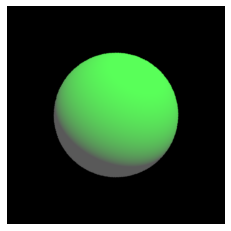

In [3]:
image_ref = mi.render(scene, params, seed=0, spp=1)
plt.axis('off')
plt.imshow(mi.util.convert_to_bitmap(image_ref));

In [4]:
# opt = mi.ad.Adam(lr=0.1)
# params[key] = mi.Color3f(1, 1, 0)

# opt[key] = params[key]
# params.update(opt);

# for i in range(25):
#     image = mi.render(scene, params, seed=0, spp=1)

#     loss = relmse(image, image_ref)
#     dr.backward(loss)

#     opt.step()

#     opt[key] = dr.clamp(opt[key], 0.0, 1.0)

#     params.update(opt)

#     print(f'Iteration {i} -- loss {loss[0]:.3e} --', end='\r')
# print()

# image = mi.render(scene, params, seed=0)

# plt.axis('off')
# plt.imshow(mi.util.convert_to_bitmap(image));

# print(params[key])

Remapping colors within range: [-3.23, 3.23]


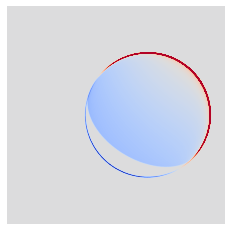

In [5]:
def apply_transformation(params, trans):
    params[key] = mi.Transform4f.translate([trans.x, trans.y, trans.z])
    params.update()

def convert_to_lum(grad_tensor):
    grad_color = dr.unravel(mi.Color3f, dr.ravel(grad_tensor[...,:3]))
    grad_lum = mi.luminance(grad_color)
    return mi.TensorXf(grad_lum, shape=(grad_tensor.shape[0], grad_tensor.shape[1]))

trans = mi.Vector3f(0.5, 0, 0)
dr.enable_grad(trans)
apply_transformation(params, trans)

image = mi.render(scene, params, seed=0, spp=16)

dr.forward(trans)

# Fetch the image gradient values
grad_image = dr.grad(image)
grad_image = convert_to_lum(grad_image)

cmap = cm.coolwarm
vlim = np.quantile(dr.abs(grad_image), 0.995)
print(f'Remapping colors within range: [{-vlim:.2f}, {vlim:.2f}]')

plt.axis('off')
plt.imshow(grad_image, cmap=cm.coolwarm, vmin=-vlim, vmax=vlim);

Iteration 249 -- loss 1.055e-04 --
[[[1, 0, 0, 0.000336441],
  [0, 1, 0, 0.00014391],
  [0, 0, 1, -0.00277094],
  [0, 0, 0, 1]]]


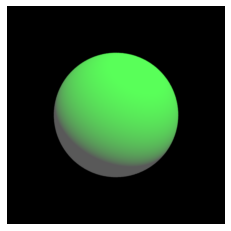

In [6]:
opt = mi.ad.Adam(lr=0.01)
opt['trans'] = mi.Vector3f(0.5, -0.2, 0.3)

def apply_transformation(params, opt):
    params[key] = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, opt['trans'].z])
    params.update()

for i in range(250):
    apply_transformation(params, opt)

    image = mi.render(scene, params, seed=0, spp=1)

    loss = relmse(image, image_ref)
    
    trans_grad = mi.Vector3f(0)
    
    for c in range(3):
        grad_in = mi.Vector3f(0, 0, 0)
        grad_in[c] = 1
        dr.set_grad(opt['trans'], grad_in)
        dr.enqueue(dr.ADMode.Forward, opt['trans'])
        dr.traverse(type(opt['trans']), dr.ADMode.Forward, flags=dr.ADFlag.ClearVertices)
        trans_grad[c] = dr.grad(loss)

    dr.set_grad(opt['trans'], trans_grad)

    opt.step()

    print(f'Iteration {i} -- loss {loss[0]:.3e} --', end='\r')
print()

image = mi.render(scene, params, seed=0)

plt.axis('off')
plt.imshow(mi.util.convert_to_bitmap(image));

print(params[key])

In [7]:
from mitsuba import Transform4f as T4f

def eval(position):
    T = T4f.translate([1, 2, 3]).rotate(dr.normalize(mi.Point3f(0.2, 0.3, 0.4)), 0.2)
    scale = 2

    T_inv = T.inverse()
    transformed_p = T_inv.transform_affine(position)
    p = transformed_p / scale
    norm_p = dr.norm(p)

    f = scale * (norm_p - 1.0)
    p_norm = dr.select(dr.neq(norm_p, 0), p / norm_p, 0)
    A_inv = mi.Matrix3f(T_inv.matrix)
    A_invT = dr.transpose(A_inv)
    dfdx = A_invT@p_norm

    dfdx2 = dr.detach(dfdx)
    dfdx_outer = mi.Matrix3f(dfdx2 * dfdx2[0], dfdx2 * dfdx2[1], dfdx2 * dfdx2[2])
    denom = norm_p * scale
    dfdxx = dr.select(dr.neq(norm_p, 0), (1 - dfdx_outer) / denom, 0)

    return f, dfdx, dfdxx

p = mi.Point3f(1, 2, 3)
dr.enable_grad(p)

f, n, dndx_analytic = eval(p)
# dr.backward(f)
# dfdx = dr.grad(p)

dndx = mi.Matrix3f(0)
for i in range(3):
    f, n, dndx_analytic = eval(p)
    dr.forward(p[i])
    dndx[i] = dr.grad(n)
print(f, n)
# print(dfdx)
# print(n)

print(dndx)
print(dndx_analytic)


[-1.999999761581421] [[-0.07708980143070221, -0.8744156956672668, -0.4790138304233551]]
[[[3986185.25, -270309.34375, -148078.21875],
  [-270309.34375, 943946.625, -1679624.375],
  [-148078.203125, -1679624.375, 3089900.75]]]
[[[3986185.5, -270309.3125, -148078.203125],
  [-270309.3125, 943946.6875, -1679624.25],
  [-148078.203125, -1679624.25, 3089900.75]]]


In [8]:
def normalize_grad(v):
    norm = dr.norm(v)
    inv_norm = dr.select(dr.neq(norm, 0), 1 / norm, 0)
    s = v * inv_norm
    sos = mi.Matrix3f(s * s[0], s * s[1], s * s[2])
    return inv_norm * (1 - sos)

film_size = mi.ScalarVector2i(100, 80)
crop_size = mi.ScalarVector2i(100, 80)
to_world = T4f.translate([1, 2, 3]).rotate(dr.normalize(mi.Point3f(0.2, 0.3, 0.4)), 0.2)

m_principal_point_offset = mi.Vector2i(0)
camera_to_sample = mi.perspective_projection(film_size, crop_size, mi.ScalarVector2i(0, 0), 40, 0.1, 1000)
sample_to_camera = camera_to_sample.inverse()

scaled_principal_point_offset = film_size * m_principal_point_offset // crop_size

def u_to_d(u):
    near_p = sample_to_camera @ \
            mi.Point3f(u.x + scaled_principal_point_offset.x,
                      u.y + scaled_principal_point_offset.y,
                      0)

    d = dr.normalize(mi.Vector3f(near_p))
    d = to_world @ d

    dddu = mi.Matrix3f(to_world.matrix) \
        @ normalize_grad(near_p) \
        @ dr.transpose(mi.Matrix3f(sample_to_camera.matrix)) \
        / sample_to_camera.matrix[3,3]

    return d, dddu

def d_to_u(d):   
    u = camera_to_sample @ to_world.inverse() @ d
    u /= u.z
    u = mi.Vector2f(u.x, u.y)

    du_dd = mi.Matrix3f(camera_to_sample.matrix)@mi.Matrix3f(to_world.inverse().matrix)

    return u, du_dd

position_sample = mi.Vector2f(0.1, 0.3)
dr.enable_grad(position_sample)
dir, d_dir_du_analytic = u_to_d(position_sample)
u = d_to_u(dir)

d_dir_du = mi.Matrix3f(0)
for i in range(2):
    dir, d_dir_du_analytic = u_to_d(position_sample)
    dr.forward(position_sample[i])
    d_dir_du[i] = dr.grad(dir)

du_ddir = mi.Matrix3f(0)
dir = dr.detach(dir)
dr.enable_grad(dir)
for i in range(3):
    u, du_dd = d_to_u(dir)
    dr.forward(dir[i])
    du_ddir[i] = mi.Vector3f(dr.grad(u).x, dr.grad(u).y, 0)
du_ddir_analytic = mi.Matrix3f(dr.inverse(mi.Matrix2f(dr.transpose(d_dir_du_analytic)@d_dir_du_analytic)))@dr.transpose(d_dir_du_analytic)

print(u)
print(d_dir_du)
print(d_dir_du_analytic)
print(du_ddir)
print(du_ddir_analytic)
# print(du_dd)
print(mi.Vector3f(1, 1, 1)@d_dir_du)

[[0.09998994320631027, 0.29997003078460693]]
[[[-0.6406628489494324, 0.018694059923291206, 0.0],
  [0.019545480608940125, -0.5488349199295044, 0.0],
  [0.18540972471237183, 0.05817750468850136, 0.0]]]
[[[-0.6406630277633667, 0.018694059923291206, 0.0],
  [0.019545480608940125, -0.5488349199295044, 0.0],
  [0.18540972471237183, 0.05817750096321106, 0.0]]]
[[[-1.438740849494934, -0.004276650957763195, 0.4219626486301422],
  [0.005071253515779972, -1.7997187376022339, 0.20724546909332275],
  [0.0, 0.0, 0.0]]]
[[[-1.4388840198516846, -0.004277101717889309, 0.42200449109077454],
  [0.005071737803518772, -1.7998982667922974, 0.20726610720157623],
  [0.0, 0.0, 0.0]]]
[[-0.43570762872695923, -0.47196337580680847, 0.0]]
